<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/test_MGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

logdir = "logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


Populating the interactive namespace from numpy and matplotlib


In [0]:
#sess=tf.InteractiveSession()
dtype=np.float64

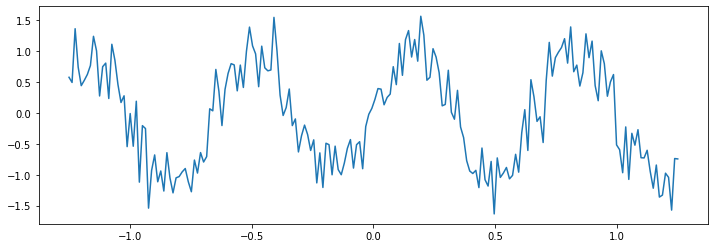

In [0]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
y=y+np.random.normal(loc=0,scale=np.sqrt(0.1),size=200)
plt.plot(x,y)
plt.show()

In [0]:
layer_count=0
DGP_count=0
class Layer:
    loss=None
    # input size for the next layers will be equal to the latent variable size of the previous layer
    def __init__(self, sess, input_size, output_size, DGP_output_size, input_layer=False, limit=1.25,
               a_initial_val=10.0, ls_initial_val=10.0, obs_nv_initial_val=0.0, 
               learning_rate=0.05):
        global layer_count
        layer_count+=1;
        global DGP_count
        self.output_size=output_size
        self.input_size=input_size
        self.layer_count=layer_count
        with tf.variable_scope("DGP_{}_layer_{}".format(DGP_count,layer_count)):
            # generate training variable of the layer
            # a - amplitude
            # ls - length scale
            # obs_nv - observation noise variance
            # these variables will be optimized during the training

            # finfo : Machine limits for floating point types
            # tiny : The smallest positive usable numbe
            # softplus: a smooth approximation of a rectifier 
            # rectifier(x) = max(0,x)
            # softplus(x) = log(1+exp(x))
            tiny=np.finfo(np.float64).tiny

            a_variable=tf.Variable(initial_value=a_initial_val,name="amplitude",dtype=dtype)
            self.a=(tiny + tf.nn.softplus(a_variable))

            ls_variable=tf.Variable(initial_value=ls_initial_val,name="length_scale",dtype=dtype)
            self.ls=(tiny + tf.nn.softplus(ls_variable))

            obs_nv_variable=tf.Variable(initial_value=obs_nv_initial_val,name="observation_noise_variance",dtype=dtype)
            self.obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))

            # use Exponentiated quadratic kernel
            # or could be called squared exponential, Gaussian, or radial basis function
            # k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
            self.kernel = tfk.ExponentiatedQuadratic( self.a, self.ls )

            # define the number of the inducing points
            self.num_inducing_points=50

            # we have to make trainable inducing points
            init_inducing=np.linspace(-limit,limit,self.num_inducing_points,dtype)[...,newaxis]
            self.inducing_ind_pts=tf.Variable(init_inducing,dtype=np.float64,name='inducing_index_points')

            init_loc=np.zeros([self.num_inducing_points],dtype=dtype)
            self.variational_ind_obs_loc=tf.Variable(init_loc,name="variational_inducing_observations_loc")

            init_scale=np.eye(self.num_inducing_points,dtype=dtype)
            self.variational_ind_obs_scale=tf.Variable(init_scale,name="variational_inducing_observations_scale")

            self.input_placeholder = tf.placeholder(dtype, [None,input_size], name='layer_input')
#             self.output_placeholder = tf.placeholder(dtype, [None,DGP_output_size], name='layer_output')
            
#             self.loss_placeholder = tf.placeholder(dtype, () ,name='loss_input')

            self.posteriors=[]
            self.priors=[]
            self.optimizer=[]
            self.train_op=[]
            self.loss=[0.0]*output_size
            
            # construct the VGP distribution(s)
            for i in range(output_size):
                
                self.posteriors.append(tfd.VariationalGaussianProcess(kernel=self.kernel, 
                                                                        index_points=self.input_placeholder,
                                                                        inducing_index_points=self.inducing_ind_pts,
                                                                        variational_inducing_observations_loc=self.variational_ind_obs_loc,
                                                                        variational_inducing_observations_scale=self.variational_ind_obs_scale))

                self.priors.append(tfd.GaussianProcess(tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(),
                                                           self.input_placeholder))
                
#                 prior=self.priors[i]
                    
            
#                 # compute the lower bound terms
#                 ################################################
#                 ##
#                 ##   (Equation 17 - Doubly stochastic DGP paper)
#                 ##
#                 ################################################
#                 #self.variational_posterior=sess.run(self.variational_posterior,feed_dict={self.input_placeholder: X})
                
#                 variational_posterior=self.posteriors[i]
                
# #                 # compute the log probabilities
# #                 log_probs = self.posteriors[-1].log_prob(self.output_placeholder)

# #                 # Reduce sum over the data dimensions
# #                 likelihood_term = tf.reduce_sum(log_probs,axis=-1)

# #                 # Reduce mean over the batch dimensions
# #                 likelihood_term = tf.reduce_mean(likelihood_term)

#                 # Compute the KL divergence term
#                 kl_term = variational_posterior.kl_divergence(prior)

#                 # Reduce over the dimension.
#                 kl_term = tf.reduce_mean(kl_term)
                
#                 self.loss[i] = self.loss_placeholder - kl_term

#                 self.optimizer.append(tf.train.AdamOptimizer())
#                 self.train_op.append(self.optimizer[i].minimize(np.abs(self.loss_place_holder)))
                
            sess.run(tf.initialize_all_variables())  
            
    def _sample(self,sess):
        samples=[]
        for posterior in self.posteriors:
            samples.append(posterior.sample())
        return samples
    
    def update_prior(self,sess):
        for i in range(len(self.priors)):
            self.priors[i]= self.posteriors[i]

    def __call__(self, sess, x):
        #self.variational_posterior=sess.run(self.variational_posterior,feed_dict={self.input_placeholder: X})
        self.input_placeholder=x
        self.sample=self._sample(sess)
        return self.sample


In [0]:
class DGP:
    def __init__(self, X, Y, num_hidden_layers=2, latent_size=1):
        global DGP_count
        DGP_count+=1

        global layer_cont
        layer_count=0

        input_size=X.shape[1]
        output_size=Y.shape[1]

        self.input_size=input_size
        self.output_size=output_size
        self.num_hidden_layers=num_hidden_layers
        self.latent_size=latent_size

        self.X=X
        self.Y=Y

        self.layers=[]
        
        self.sess=tf.Session()

        self.build_model(self.sess)
        
        self.input_placeholder=tf.placeholder(dtype,[None,self.input_size],name="DGP_input")
        self.output_placeholder=tf.placeholder(dtype,[None,self.output_size],name="DGP_output")
        
        self.loss_ = self.loss()
        self.optimizer = tf.train.AdamOptimizer()
        self.train_op = self.optimizer.minimize(self.loss_)
        
    
    def build_model(self,sess):
        self.layers.append(Layer(sess,self.input_size,self.latent_size,self.output_size))
        for i in range(self.num_hidden_layers):
            self.layers.append(Layer(sess,self.latent_size,self.latent_size,self.output_size))
        self.layers.append(Layer(sess,self.latent_size,self.output_size,self.output_size))
    
    def loss(self):
        x=self.input_placeholder
        loss=0.0
        kl_term=0.0
        for layer in self.layers:
            x=layer(self.sess,x)
            for i in range(layer.output_size):
                kl=layer.posteriors[i].kl_divergence(layer.priors[i])
                kl_term+=tf.reduce_mean(kl)
            posteriors=layer.posteriors
        lh_term=0.0
        for posterior in posteriors:
            lh=posterior.log_prob(self.output_placeholder)
            lh=tf.reduce_sum(lh,axis=-1)
            lh_term+=tf.reduce_mean(lh)
        loss = lh_term - kl_term
        return loss
    
#     def optimize(self, X , Y,it):
#         x= self.X
#         x=x.reshape((-1,1))
#         k=0
#         lh_term=self.layers[-1].posteriors[-1].log_prob(Y)
#         lh_term=tf.reduce_sum(lh_term,axis=-1)
#         lh_term=tf.reduce_mean(lh_term)
#         loss=self.sess.run(lh_term,feed_dict=)
#         for layer in self.layers:
#             k+=1
#             x=x.reshape((-1,1))            
#             feed_dict={layer.input_placeholder:x,
#                           layer.loss_placeholder:loss}
#             for i in range(layer.output_size):
#                 loss+=self.sess.run(layer.loss[i],feed_dict)
#                 self.sess.run(layer.train_op[i],feed_dict)
#             layer.update_prior(self.sess)
#             x=layer(self.sess,feed_dict)
#             x=np.array(x).T
            
    def train(self,X,Y,niter=100):
        print(X.shape,Y.shape)
        for i in range(niter):
            self.sess.run(self.train_op,feed_dict={self.input_placeholder:X,
                                                  self.output_placeholder:Y})
#             x=input()
   
    def predict(self,X):
        Y=[]
        f_i=x
#         print(f_i)
        count=1
        for layer in self.layers:
            f_i=f_i.reshape((-1,1))
            feed_dict={layer.input_placeholder:f_i}
            for i in range(layer.output_size):
                ################################################
                ##
                ##   (Equation 15 - Doubly stochastic DGP paper)
                ##
                ################################################

                posterior=layer.posteriors[i]
                # Draw a sample from the variational posterior
#                 latent_sample = posterior.sample()
#                 latent_sample=layer(self.sess,feed_dict)

#                 lat=self.sess.run(latent_sample,feed_dict)
#                 print(lat)
#                 mean,var=tf.nn.moments(latent_sample,axes=0)
#                 covariance=tfp.stats.covariance(latent_sample,latent_sample,sample_axis=0, event_axis=None)

                mean=posterior.mean()
                covariance=posterior.scale.matmul(posterior.scale.to_dense(), adjoint_arg=True)

                m,cov=self.sess.run([mean,covariance],feed_dict)
                first_term=m
                
                size=m.size
                k=np.eye(size,dtype=np.float64)
                z=np.zeros(size,dtype=np.float64)
                e=np.random.multivariate_normal(z,k)
                sqr=np.sqrt(cov)
                print("cov",sqr.size,np.isnan(sqr).sum())
                
                # TODO check sampe's variance in variational GP class
                second_term= np.dot(sqr,e)
                print("sec",second_term)
                
                layer_pred=first_term + second_term
                #print(e,np.sqrt(v))
                f_i=layer_pred
                print(f_i.shape)
                print("111111111")
#                 print(f_i)

            count+=1
            print("f_i",f_i)
        Y=f_i
        return Y


In [0]:
tf.reset_default_graph()
print(x.shape)
x=x.reshape((-1,1))
y=y.reshape((-1,1))

(200, 1)


In [0]:
dgp=DGP(x,y)

In [0]:
dgp.train(x,y)

(200, 1) (200, 1)


InvalidArgumentError: You must feed a value for placeholder tensor 'DGP_1_layer_1/layer_input' with dtype double and shape [?,1]
	 [[node DGP_1_layer_1/layer_input (defined at <ipython-input-12-33deb9b9eabc>:56) ]]

Original stack trace for 'DGP_1_layer_1/layer_input':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ali/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/ali/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ali/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ali/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-826032c6475e>", line 1, in <module>
    dgp=DGP(x,y)
  File "<ipython-input-13-d2771ce8d63c>", line 24, in __init__
    self.build_model(self.sess)
  File "<ipython-input-13-d2771ce8d63c>", line 36, in build_model
    self.layers.append(Layer(sess,self.input_size,self.latent_size,self.output_size))
  File "<ipython-input-12-33deb9b9eabc>", line 56, in __init__
    self.input_placeholder = tf.placeholder(dtype, [None,input_size], name='layer_input')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [0]:
print(dgp.predict(x))

/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in sqrt


cov 40000 21156
sec [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
(200,)
111111111
f_i [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
